<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymorphy2 --quiet

In [2]:
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
print('Python v:', sys.version)
print('Sklearn v:', sklearn.__version__)

Python v: 3.8.15 (default, Oct 12 2022, 19:14:39) 
[GCC 7.5.0]
Sklearn v: 1.0.2


In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/toxic_original_RU.csv')
data.head(7)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0


In [4]:
COL_TEXT='comment'
COL_LABEL='toxic'

In [5]:
data['comment'] = data['comment'].values.astype('U')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


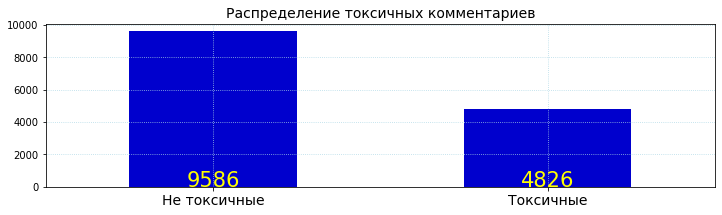

In [6]:
fig, ax = plt.subplots(figsize=(12, 3))

toxic = (data['toxic'].value_counts()).plot(kind='bar',  
                                   color='mediumblue').set_title(
    'Распределение токсичных комментариев', 
    fontdict={'fontsize': 14}
)
ax.set_xticklabels(['Не токсичные', 'Токсичные'], rotation=0, fontsize=14, )
plt.grid(color='lightblue', linestyle=':')
plt.text(0, 1, (data['toxic'].value_counts())[0], horizontalalignment='center', fontsize=21, color='yellow')
plt.text(1, 1, (data['toxic'].value_counts())[1], horizontalalignment='center', fontsize=21, color='yellow')
plt.show()

In [7]:
print('Количество дубликатов -', data.duplicated().sum())

Количество дубликатов - 0


In [8]:
morph = pymorphy2.MorphAnalyzer()
def lemmatize_word(word: str) -> str:
    try:
        p = morph.parse(word)[0]
        return p.normal_form 
    except:
        return word

In [9]:
def clear_text(text):
    text= text.lower()
    clear = re.sub(r'[^а-яА-Я]', ' ', text) # все кроме букв
    clear = re.sub(r"\s+[а-яА-Я]\s+", ' ', clear) # одиночные буквы
    clear = re.sub(r'\s+', ' ', clear) # лишние пробелы
     
    return ' '.join([lemmatize_word(word) for word in clear.split(' ')])

In [10]:
%%time
data['comment'] = data['comment'].apply(clear_text)

CPU times: user 1min 12s, sys: 310 ms, total: 1min 12s
Wall time: 1min 12s


In [11]:
data.head(7)

,comment,toxic
0,верблюд то за что дебил бл,1.0
1,хохол это отдушина затюканый россиянин мол вон...,1.0
2,собака собачий смерть,1.0
3,страница обновить дебил это тоже не оскорблени...,1.0
4,ты не убедить страничный пдф тот что скрипаль ...,1.0
5,для какой стан являться эталон современный сис...,1.0
6,в шапка быть ссылка на инф по текущий фильм ма...,0.0


In [12]:
FILE_NAME_CLEAR_DATA='toxic_comment_RU_cleaned.csv'
data=data.astype({'toxic': 'int64'})
data.to_csv(FILE_NAME_CLEAR_DATA, encoding='utf-8', index=False)
# files.download(FILE_NAME)

**Загружаем ощищенные данные**

In [13]:
FILE_NAME_CLEAR_DATA='toxic_comment_RU_cleaned.csv'
df = pd.read_csv('https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/toxic_cleaned_RU.csv')
df.head(7)

,comment,toxic
0,верблюд то за что дебил бл,1
1,хохол это отдушина затюканый россиянин мол вон...,1
2,собака собачий смерть,1
3,страница обновить дебил это тоже не оскорблени...,1
4,ты не убедить страничный пдф тот что скрипаль ...,1
5,для какой стан являться эталон современный сис...,1
6,в шапка быть ссылка на инф по текущий фильм ма...,0


**Взвесим tf-idf**

In [14]:
count_idf_neutral = TfidfVectorizer(min_df=3, max_df=0.8)
count_idf_toxic = TfidfVectorizer(min_df=3, max_df=0.8)

tf_idf_neutral = count_idf_neutral.fit_transform(df.query('toxic == 0')['comment'])
tf_idf_toxic = count_idf_toxic.fit_transform(df.query('toxic == 1')['comment'])

In [15]:
# Сохраним списки Idf для каждого класса
neutral_importance = pd.DataFrame(
    {'word' : count_idf_neutral.get_feature_names_out(),
     'idf' : count_idf_neutral.idf_
    }).sort_values(by = 'idf', ascending = False)

toxic_importance = pd.DataFrame(
    {'word' : count_idf_toxic.get_feature_names_out(),
     'idf' : count_idf_toxic.idf_
    }).sort_values(by = 'idf', ascending = False)

In [16]:
neutral_importance.head(21)

,word,idf
0,аба,8.781869
5180,прижать,8.781869
1799,закурить,8.781869
1801,зала,8.781869
5199,прикрываться,8.781869
1805,залипать,8.781869
5192,приказать,8.781869
5184,признание,8.781869
1813,замереть,8.781869
5164,пригодный,8.781869


In [17]:
toxic_importance.head(21)

,word,idf
0,аборт,8.095686
2540,подменить,8.095686
2547,подонок,8.095686
979,жёлчь,8.095686
2552,подписывать,8.095686
975,журналистика,8.095686
2557,подрочить,8.095686
2563,подстилка,8.095686
2564,подтвердить,8.095686
967,жирух,8.095686


**Разделение выборок, преобразование текстов**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['toxic'], test_size=.2, random_state=7)

**Векторизация текста**

In [19]:
vectorize = TfidfVectorizer(min_df=3, max_df=0.8)

In [20]:
# рассчитываем TF-IDF слов
X_train = vectorize.fit_transform(X_train)
X_test = vectorize.transform(X_test)

**LogisticRegression**

In [21]:
clf = LogisticRegression(solver = 'lbfgs',
                                    random_state = 21,
                                    max_iter= 10000,
                                    n_jobs= -1)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=21)

In [22]:
pred = clf.predict(X_test)

**Отобразим матрицу ошибок**

Accuracy: 87.37 %
Recall: 70.03 %
Precision: 90.75 %
F1-score: 79.06 % 



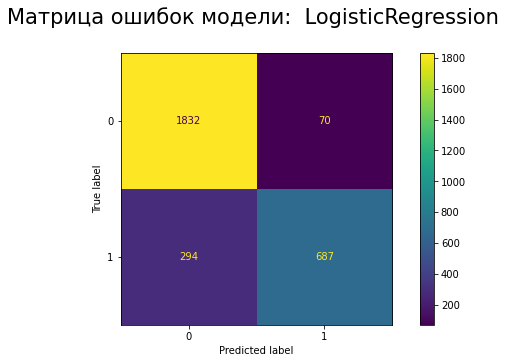

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
_ = ax.set_title(f"Матрица ошибок модели:  {clf.__class__.__name__} \n", fontdict={'fontsize':21})
print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
print("Recall:", score_to_percent(recall_score(y_test, pred)))
print("Precision:",score_to_percent(precision_score(y_test, pred)))
print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')

**Отобразим ROC - кривую**

LogisticRegression: ROC AUC=0.938


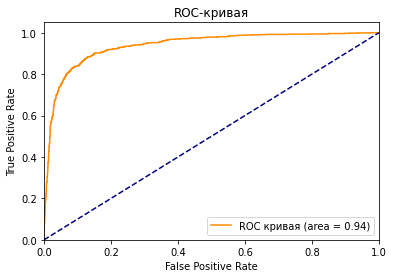

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# сохраняем вероятности только для положительного исхода
lr_probs = clf.predict_proba(X_test)[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

#**Отобразим топ нейтральных и токсичных слов в текстах датасета**

In [25]:
def wordplot(txt_toxic, txt_neutral):
    
    txt_toxic=' '.join(txt_toxic)
    txt_neutral=' '.join(txt_neutral)

    fig, axs = plt.subplots(figsize=(20, 12))
    plt.axis('off')
    ax = fig.add_subplot(1, 2, 1)

    WIDTH=1600
    HEIGHT=1600
    
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Blues',
                          max_words=200,
                          mask=None
                          ).generate(txt_neutral)
    plt.axis('off')

    FONTSIZE=21
    INTERPOLATION='bilinear'

    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('NEUTRAL \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=1)

    ax = fig.add_subplot(1, 2, 2)
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Oranges',
                          max_words=200,
                          mask=None, 
                          ).generate(txt_toxic)
    
    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('TOXIC \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=0)
    plt.axis('off')
    plt.show()

In [26]:
feature_to_coef = { word: coef for word, coef in zip(vectorize.get_feature_names_out(), clf.coef_[0]) }

toxic, neutral   = [], []

for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:50]:
    toxic.append(best_negative[0])

for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1])[:50]:
    neutral.append(best_positive[0])

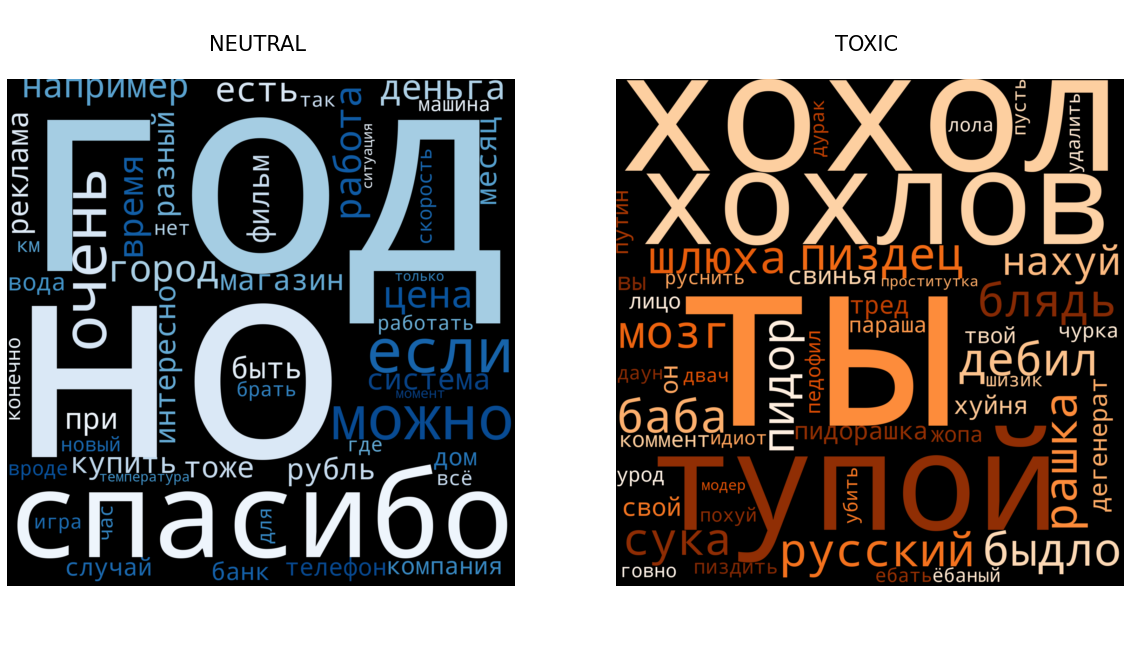

In [27]:
wordplot(toxic, neutral)